# Distance-based Generalized Sensitivity Analysis: An Application to the DNAPL Test Case
Author: Jian Wang

## Introduction

In this notebook, we will give an introduction on how to apply DGSA step by step to the presented case study, DNAPL test case, in the book as an aid to understand the procedure of DGSA, and further help users to apply DGSA on their own dataset.

Here, a simplified version of the DNAPL test case where the number of uncertain parameters was reduced to 6, will be presented. These parameters include the mean and standard deviation of the hydraulic conductivity (***Kmean*** and ***Ksd*** respectively), the covariance model (***KCov***), the anistropy angle(***Kangle***) of the hydraulic conductivity, the river gradient (***HrivGrad***) and the range of the Matern covariance model (***Hrange***). All other parameters are fixed to their mean values. The response variable is the pollutant arrival time, which is a time-varying variable. More detail on the description of the DNAPL test case can be referred to Chapter 2 of the book (Scheidt et al., 2017).

By using DGSA, we will investigate: 1) main effect of 6 parameters, and 2) influence of two-way interactions among these parameters on the response variable.

## Loading Parameter Values

Two hundred parameter combinations were sampled by using Latin Hypercube Sampling (LHS) and saved as matlab ***.mat*** file. Here, we didn't show the sampling procedure, but directly loaded the generated file from the workpath. 

In [1]:
addpath('../src/DGSA/');
addpath('../data/DGSA');
load('ParamValues.mat','ParamsValues','ParamsNames')
ParamsNames = {'Kmean';'Ksd';'Krange';'HrivGrad';'Hrange';'KCov'};

The ***.mat*** file for parameter values is simply a matrix, with each column corresponding to one parameter,as partially shown in the following figure 

<img src="../figures/DGSA/Parameters.PNG",width="400",style="float: center">

## Loading Model Response Data

Based on the parameter values, 200 models are generated; and for each model, a time series containing 217 time intervals can be obtained by proxy flow simulation. We loaded the response result directly from current directory.

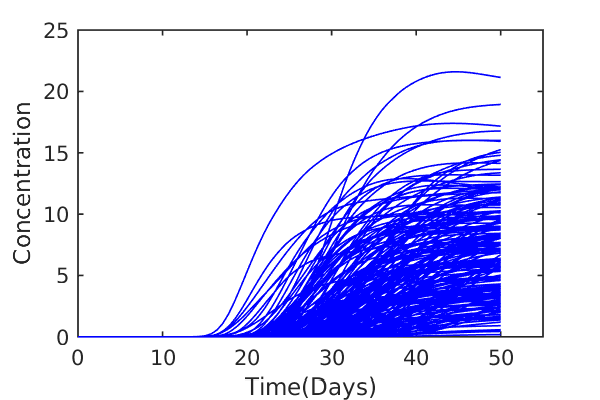

In [2]:
%plot inline -s 600,400

load('SimulationOutput.mat','AllCDrinkingWell','OutputTime','TimeVecDays')
figure;
plot(OutputTime/86400,AllCDrinkingWell,'b-')
xlim([0,55]);ylim([0,25])
xlabel('Time(Days)')
ylabel('Concentration')

Note that users needs to create and replace with their own input parameter and response dataset before applying DGSA into their own case study.

## Clustering the Response Results

DGSA is based on the following principle: the response results are first classified into a limited set of classes; for any given parameter, if the frequency distribution is the same among the classes, then the model response is insensitive to the parameter; otherwise, it is sensitive. 

DGSA firstly applies clustering methods, such as $k$-means, $k$-medoids, to partition the response variables into several classes. 

### Evaluate distance matrix between model responses
Since each model response is a time-varying variable, the distance between any pair of models is calculated as the Euclidean distance implemented on each time interval.

In [3]:
d = pdist(AllCDrinkingWell); 

### $k$-medoids clustering analysis
Before proceeding with clustering analysis, an appropriate number of clusters need to be predefined. It can be determined using Silhouette index (Rousseeuw, 1987), for example. Also, user can determine a preferred cluster number based on experience. Here, for our case study, the cluster number is set to 3.

In [4]:
%number of clusters can be changed according to specific applications
nbclusters = 3;
%20 is iteration number to find optimal clustering result
Clustering = kmedoids(d ,nbclusters,20);

minDist  2988.94, iter 1


Here, the return value ***Clustering*** is a structure containing three members: cluster labels for each model response, medoids of each cluster and cluster size.

## Evaluate Main Effect

For any given parameter, the difference between the prior empirical distribution function and the class-conditional empirical distribution function is used to evaluate the effect of the parameter on the response variable. The difference is quantitatively measured by the distance between the two distributions, denoted as ***cdf distance***. The distance is defined as

$$\hat{d}^{(k)}_n = f_{\Delta{cdf}} (\hat{F}(x_n),\hat{F}(x_n|c_k)) \quad k = 1,...K,$$

where $x_n$ is the $n$-th inputer parameter ($n = 1,...,N_p$), and $c_k$ denotes the $k$-th cluster obtained from previous cluster analysis. This distance is determined by evaluating the L1-norm, representing the area between the two distribution curves as illustrated in following figure (Fenwick et al., 2014): 

<img src="../figures/DGSA/distOfDistribution.PNG",width="400",style="float: center">

### Plot CDF of each parameter for each class
For each parameter, we first visualize the ***cdfs*** for the parameter values as a whole and for those in each class, to inspect their differences.

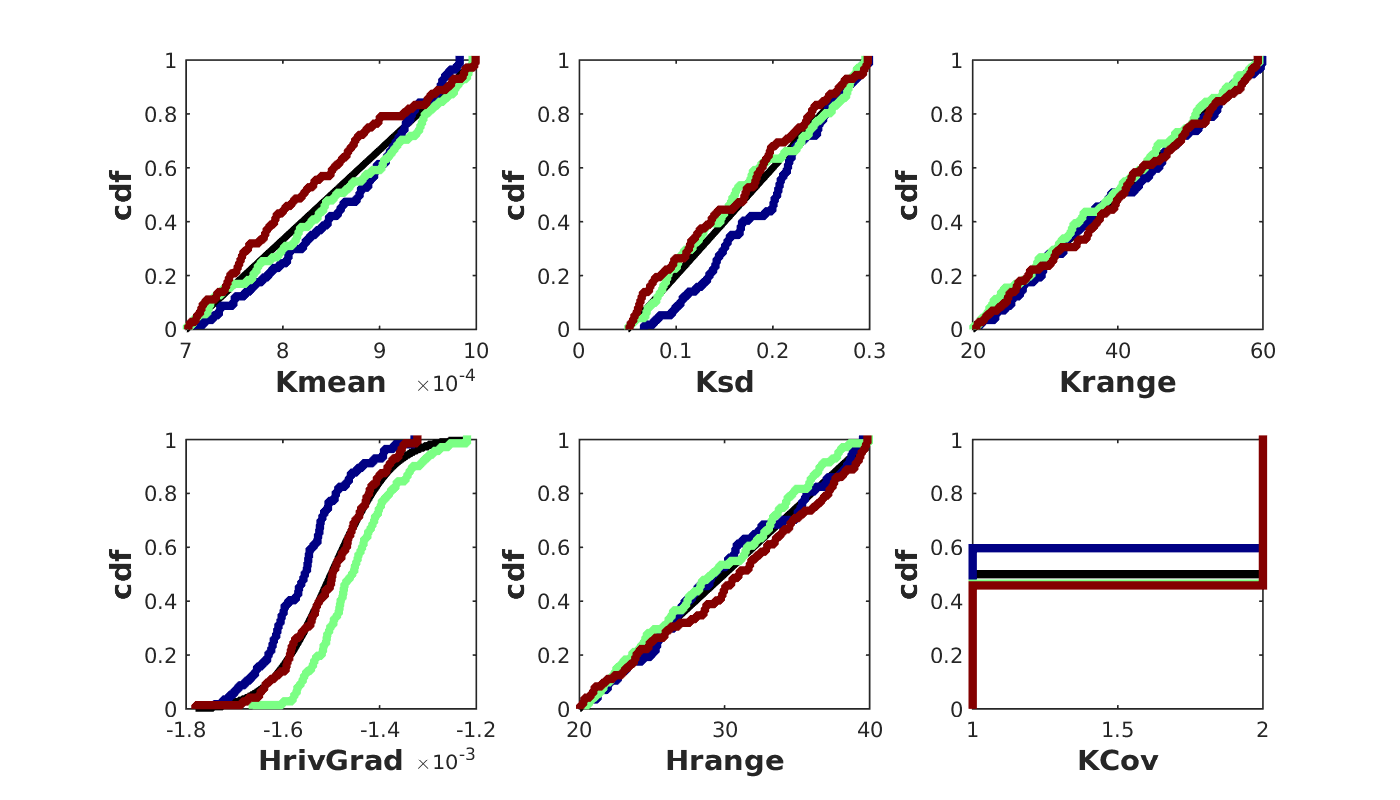

In [5]:
%plot inline -s 1400,800
cdf_MainFactor(ParamsValues,Clustering,ParamsNames);

The red, blue and green curves correspond to ***cdfs*** of all clusters, and the black one is the ***cdf*** of unclustered parameter values.

### Apply DGSA to evaluate the main effect
For the purpose of comparing sensitivities among different parameters, a standardized measure of sensitivity is defined using bootstrap resampling (double hat notation) as follows:

$$\hat{d}^{S(k)}_n = \frac {\hat{d}^{(k)}_n}{\hat{\hat{d}}^{(k)}_{n,\alpha}},$$

where $\alpha$ represents the confidence level (by default 0.95), and ${\hat{\hat{d}}^{(k)}_{n,\alpha}}$ is the $\alpha$-quantile of the distances from the resampling procedure. 
Then, an averaged sensitivity value can be calculated as

$$s(x_n) = \frac{1}{K}\sum_{k=1}^{K}\hat{d}^{S(k)}_n.$$

$s(x_n)$ is taken as the main effect of $n$-th parameter $x_n$ on the response variable. The main effect is usually visualized using the Pareto chart. Readers should be reminded that whether or not the parameter $x_n$ is sensitive depends on the difference of standardized measure of sensitivity $\hat{d}^{S(k)}_n$ (not the average sensitivity value $s(x_n)$) with respect to 1.

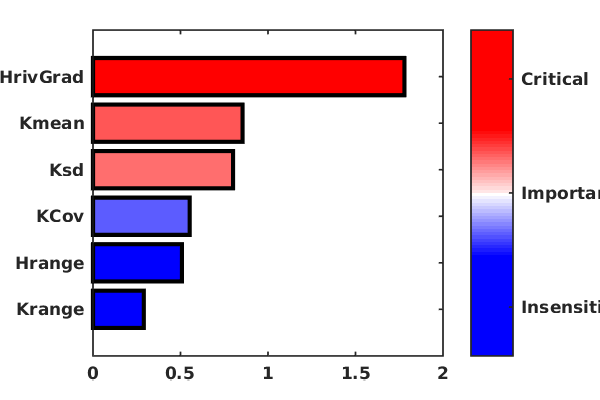

In [12]:
%plot inline -s 1600,1200

inputs = struct('PlotType','L1norm');
[PvalMainFactors,L1MainFactors,~,SensitivityMainFactorperClass] = ...
    dGSA_MainFactors(Clustering,ParamsValues,ParamsNames,inputs); 

Note that the length of the bars represent the average sensitivity value $s(x_n)$, while the color indicates the maximum of the standardized sensitivity measure over all classes for any given parameter.

Another way to represent main effect is to display $\widetilde {ASL}(\hat{d}^{(k)}_n)$ (the achieved significance level), which is defined as

$$\widetilde {ASL}(\hat{d}^{(k)}_n) = P({\hat{\hat{d}}^{(k)}_{n}}\leqslant {\hat{d}^{(k)}_n}).$$

The global sensitivity measure $s^*(x_n)$ for parameter $x_n$ is then represented by the maximum $\widetilde {ASL}$ of all classes:

$$s^*(x_n) = \max_k \widetilde{ASL}(\hat{d}^{(k)}_n)$$

Sensitivity can then be determined based on the value of confidence of the hypothesis test:
* $s^*(x_n)>\alpha$, the parameter $x_n$ is critical
* $s^*(x_n)<\alpha$, the parameter $x_n$ is insensitive
* $s^*(x_n)\thickapprox \alpha$, the parameter $x_n$ is important

Here $\alpha$ represents confidence level, and is set to 0.95 in our case study.

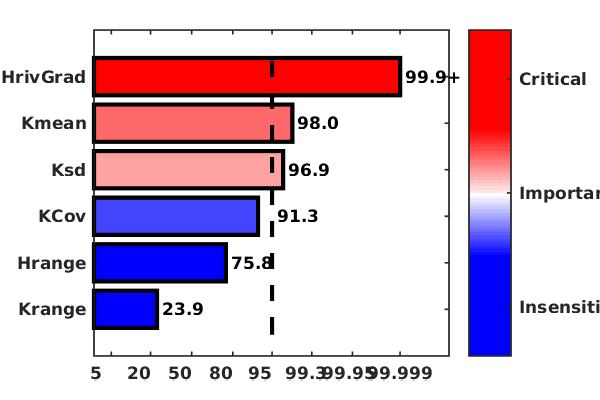

In [18]:
%plot inline -s 600,400
inputs = struct('PlotType','ASL');
[PvalMainFactors,L1MainFactors,~,SensitivityMainFactorperClass] = ...
dGSA_MainFactors(Clustering,ParamsValues,ParamsNames,inputs); 

Both of these two sensitivity measures indicate that: 1) the river gradient (***HrivGrad***) is the most influential parameter affecting the model response, and 2) in addition to ***HrivGrad***, the mean and standard deviation of the hydraulic conductivity (***Kmean*** and ***Ksd*** respectively) are also sensitive.

## Evaluate Sensitivity of Parameter Interaction

Quantifying sensitivity of two-way parameter interactions follows the exact same principle as for single-way sensitivity, namely: response is sensitive to the parameter interaction if there is significant difference between the class-conditional distribution of a parameter and the class-conditional distribution of that parameter additionally conditioned to a second parameter.
For a given class, the sensitivity measure for two-way interactions is again a function of the distance between two ***cdfs***:

$$\hat{d}_{k,n|{{n^\prime},m}} = f_{\Delta{cdf}}(\hat{F}(x_n|({x_{n^\prime},t_m),c_k}),\hat{F}(x_n,c_k)) \qquad\forall k, \forall m,$$

where $t_m$ is the $m$-th bin of conditional parameter ($m = 1,...,M$). This measure is used to determine whether there is any interaction of $x_{n^\prime}$ on $x_n$ which influences the response variable.

### Define the number of bins for each conditional parameters
The conditional parameter is usually binned into a few levels, such as low/medium/high.

In [8]:
NbBins = 3*ones(1,length(ParamsNames));
% for the covariance parameter
NbBins(end) = 2; 

### Plot CDF of each parameter for each class
DGSA models two-way interactions through conditional distributions, and therefore this measure of sensitivity is asymmetric.When the number of input parameters is $N_p$ ,then there are $N_p\times(N_p - 1)$ combinations. If $N_p$ is large, the number of interactions would be very large. Here, we only display the result for ***Kmean|Ksd in c1*** as an example.

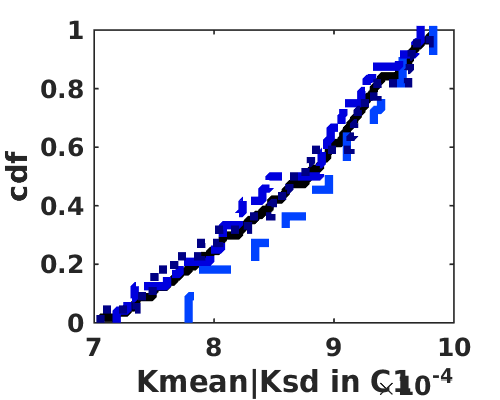

In [9]:
%plot inline -s 500,400

cdf_Interactions(ParamsValues(:,1),ParamsValues(:,2),...
Clustering,NbBins(2),1,'Kmean|Ksd in C1')

### Apply DGSA to evaluate conditional effect
Similar to the approach for main effect, a sensitivity measure of conditional interaction per class can be defined as:

$$s_k(x_n|x_{n^\prime}) = \frac{1}{M}\sum_{m=1}^M \hat{d}^S_{k,n|{{n^\prime},m}},\quad\forall k \text{ } with \text{ } \hat{d}^S_{k,n|{{n^\prime},m}} = \frac{\hat{d}_{k,n|{{n^\prime},m}}}{\hat{\hat{d}}^{(\alpha)}_{k,n|{{n^\prime},m}}}$$

where $\hat{\hat{d}}^{(\alpha)}_{k,n|{{n^\prime},m}}$ is the $\alpha$-quantile of the distances from the resampling procedure.
Also, the average measure of sensitivity over all classes can be determined

$$s(x_n|x_{n^\prime}) = \frac{1}{K}\frac{1}{M}\sum_{k=1}^K\sum_{m=1}^M \hat{d}^S_{k,n|{{n^\prime},m}}$$

then $s(x_n|x_{n^\prime})$ is the two-way interaction sensitivity measure.

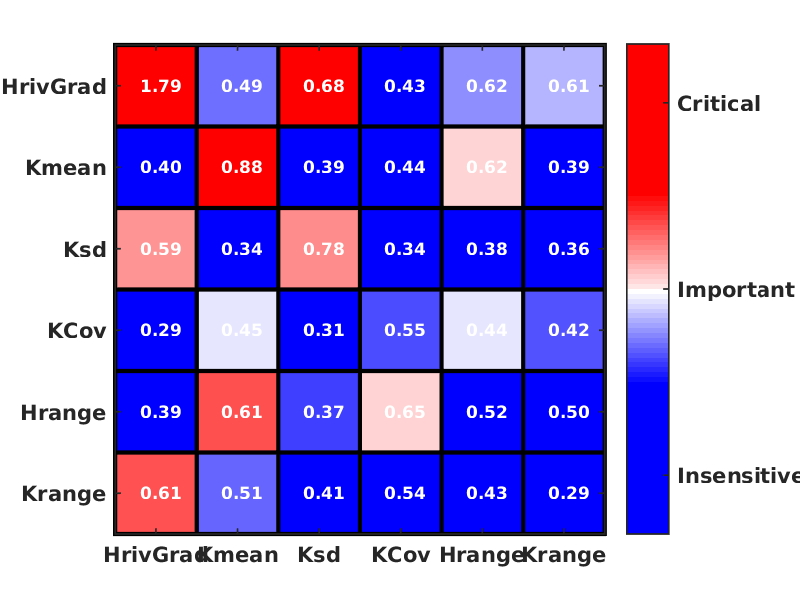

In [19]:
%plot inline -s 800,600

inputs = struct('PlotType','L1norm','L1MainFactors',SensitivityMainFactorperClass);
[ALSInteractions,L1Interactions] = dGSA_Interactions(Clustering,...
ParamsValues,NbBins,ParamsNames,inputs); 

Here, we use a table to visualize the two-way interactions, where the diagonal values show the L1norm-based sensitivity values for the main effect, and the off-diagonal values are the L1norm-based sensitivity values for the two-way interactions (row|col). Again, note that the values within the cell represent the average sensitivity measure for two-way interactions, while the color indicates the maximum of $\hat{d}^S_{k,n|{{n^\prime},m}}$ among all classess and all bins.

Also, we can evaluate the ASL-based two-way interactions as in the case of main effect. 

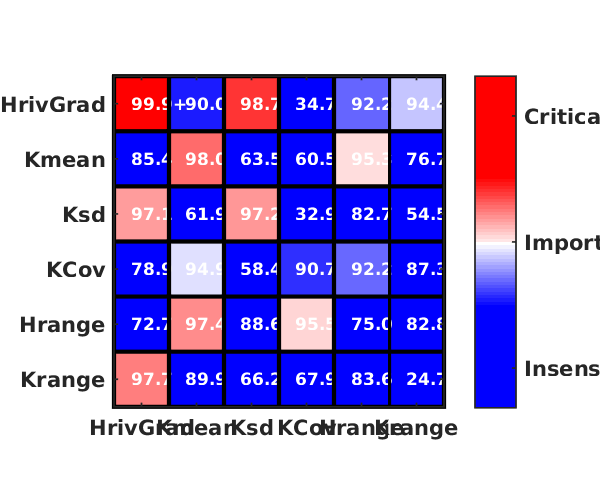

In [11]:
%plot inline -s 600,500
inputs = struct('PlotType','ASL','ASLMainFactor',PvalMainFactors);
[ALSInteractions,L1Interactions] = dGSA_Interactions(Clustering,ParamsValues,NbBins,ParamsNames,inputs); 

The results for two-way interactions show that: 1) each parameter has at least one influential interaction with another parameter, and 2) ***HrivGrad|Ksd*** is critical to the variation of the response, and 3) two-way interactions are asymmetric.

## References
Fenwick, D. S. (2014). Quantifying Asymmetric Parameter Interactions in Sensitivity Analysis: Application to Reservoir Modeling. Mathematical Geosciences , 46 (4), 493–511.

Park, J. (2016). DGSA: A Matlab toolbox for distance-based generalized sensitivity analysis of geoscientific computer experiments. Computers & Geosciences, 97, 15–29.

Scheidt, C., Li, L. and Caers, J. (2017). Quantifying Uncertainty in Subsurface systems. Wiley-Blackwell.